In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy import argmax,array
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from pickle import load
from keras.models import load_model
from numpy import argmax,array
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [ ]:
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()    
    return text

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        if len(line)<1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0],tokens[1:]
        #if image_id not in dataset ignore
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

def load_photo_features(filename, dataset):
	all_features = pickle.load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
def word_for_id(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None

def generate_desc(model, tokenizer, photo, max_length):
		in_text = 'startseq'
		for i in range(max_length):
			sequence = tokenizer.texts_to_sequences([in_text])[0]
			sequence = pad_sequences([sequence],maxlen = max_length)
			yhat = model.predict([photo,sequence],verbose=0)
			yhat = argmax(yhat)
			word = word_for_id(yhat,tokenizer)
			if word is None:
				break
			in_text += ' '+word
			if word == 'endseq':
				break	
		return in_text

def extract_features(filename):
	
	model = ResNet50()
	model.layers.pop()
	model = Model(inputs=model.inputs,outputs=model.layers[-1].output)

	image = load_img(filename,target_size=(224,224))
	image = img_to_array(image)
	image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
	image = preprocess_input(image)
	feature = model.predict(image,verbose=0)
	return feature


In [ ]:
def load_text(filename):
  file = open(filename,'r')
  text = file.read()
  file.close()
  return text

def load_description(doc):
  mapping = dict()
  for line in doc.split('\n'):
    tokens = line.split()
    if len(line)<2:
      continue
    image_id,image_desc = tokens[0],tokens[1:]
    image_id = image_id.split('.')[0]

    image_desc = ' '.join(image_desc)
    if image_id not in mapping:
      mapping[image_id] = list()
    mapping[image_id].append(image_desc)
  return mapping



In [ ]:
weights = '/content/drive/My Drive/College/IRS Innovative/ResNet50/model_19.h5'
model = load_model(weights)


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 1000)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
tokenizer = load(open('/content/drive/My Drive/College/IRS Innovative/tokenizer_resnet50.pkl', 'rb'))
max_length = 34


In [ ]:
test_image = '/content/drive/My Drive/College/IRS Innovative/Images/dog3.jpg'

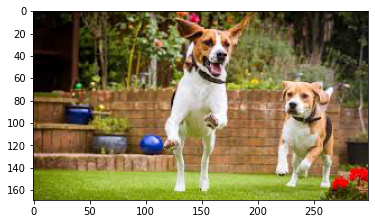

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(test_image)
plt.imshow(img)

In [ ]:
photo = extract_features(test_image)

In [ ]:
predicted_description = generate_desc(model, tokenizer, photo, max_length)
print_description = ' '.join(predicted_description.split(' ')[1:-1])

In [ ]:
print(print_description)

white dog is running through the grass


In [ ]:
testFile = '/content/drive/My Drive/College/IRS Innovative/flicker8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt'
testImagesLabel = load_set(testFile)
test_descriptions = load_clean_descriptions('/content/drive/My Drive/College/IRS Innovative/flicker8k-dataset/Flickr8k_text/descriptions.txt', testImagesLabel)


In [ ]:
def sort_Images(Files):
    sorted(Files,reverse=True)
    matchFiles = set()
    for x in Files:
        matchFiles.add(x[1])
    return matchFiles

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(words):
    # stop word removal
    tokens = []
    for token in words:
        if not token in stop_words:
            tokens.append(token) 
    # stemming
    words = []
    for token in tokens:
        words.append(ps.stem(token))
    return words

def preprocess_words(list_words):
    # stop word removal
    list_tokens = []
    for words in list_words:
        list_tokens.append(preprocess_text(words)) 
    return list_tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
matchedFiles = set()
for img in testImagesLabel:
  if len(matchedFiles) > 5:
    break
  actual, predicted = list(), list()
  yhat = predicted_description.split()
  yhat = preprocess_text(yhat)
  predicted.append(yhat)
  references = [d.split() for d in test_descriptions[img]]
  references = preprocess_words(references)
  actual.append(references) 
  bleu_score_1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
  bleu_score_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
  bleu_score_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.34, 0))
  bleu_score_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
  bleu_score = ( 8*bleu_score_4 + 4*bleu_score_3 + 2*bleu_score_2 + bleu_score_1 )/15
  if bleu_score > 0.86:
    matchedFiles.add((bleu_score,img))

matchedFiles = sort_Images(matchedFiles)
len(matchedFiles)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 Score =  0.8685015774180418
 Score =  0.8685015774180418
 Score =  0.8685015774180418
 Score =  0.8685015774180418
 Score =  0.8685015774180418
 Score =  0.8685015774180418


6

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
path = '/content/drive/My Drive/College/IRS Innovative/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/'

def show_images(images, cols = 1, titles = None):
    
    
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        img_path = path + image + '.jpg'
        output = mpimg.imread(img_path)
        if output.ndim == 2:
            plt.gray()
        plt.imshow(output)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

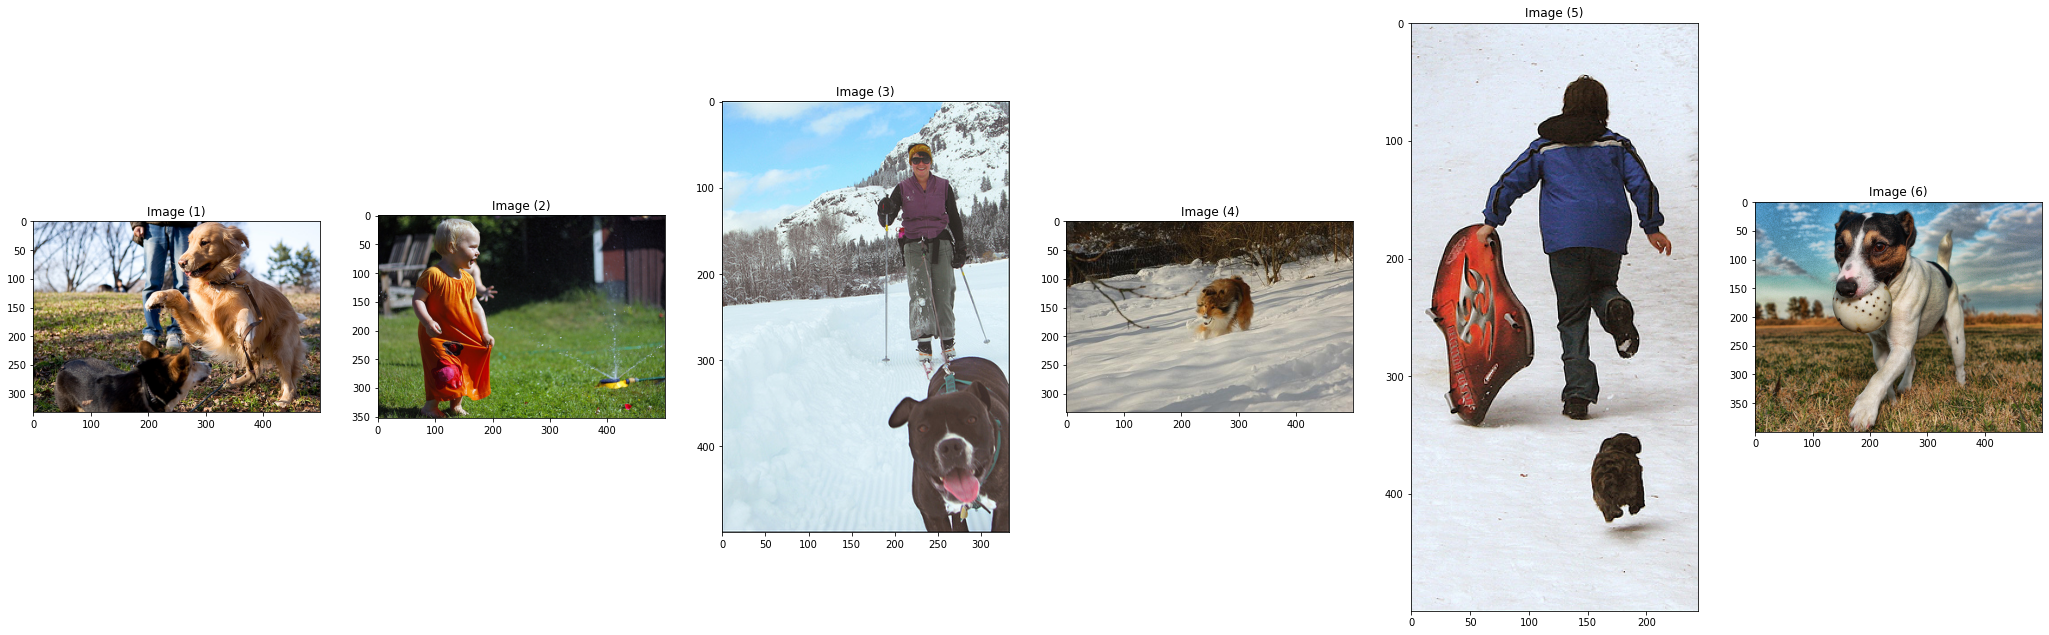

In [ ]:
show_images(matchedFiles)